# MLOps Example

This is an example of a machine learning workflow within a notebook.  
We will example each step in this notebook.  
And later on we decompose each step and containerized them as components for building a ML pipeline.

In [1]:
# install packages
!pip3 install -U scikit-learn
!pip3 install pandas
!pip3 install xgboost
!pip3 install matplotlib

In [2]:
# imports
import pickle
import pathlib
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn import preprocessing
import xgboost as xgb
from xgboost import plot_tree
from matplotlib import pyplot as plt
import numpy as np

## 1.0 Data Input

In this step, the training data for training a machine learning model is ingested and stored.

In [3]:
def data_ingestion(url, output_path='new_data.txt'):
    '''The function fetches data by given URL.
    
    '''
    
    p = pathlib.Path('.')
    p = p / output_path
    if p.exists():
        print('Output file already exists.')
        with open(p, 'r') as f:
            ret = f.read()
    else:
        with open(p, 'w') as f:
            r = requests.get(url)
            f.write(r.text)
            ret = r.text
        
    return ret

In [4]:
# The url links to the IRIS dataset
url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'

In [5]:
# Get the file and store at default output path
data = data_ingestion(url)

Output file already exists.


In [6]:
data

'"sepal.length","sepal.width","petal.length","petal.width","variety"\n5.1,3.5,1.4,.2,"Setosa"\n4.9,3,1.4,.2,"Setosa"\n4.7,3.2,1.3,.2,"Setosa"\n4.6,3.1,1.5,.2,"Setosa"\n5,3.6,1.4,.2,"Setosa"\n5.4,3.9,1.7,.4,"Setosa"\n4.6,3.4,1.4,.3,"Setosa"\n5,3.4,1.5,.2,"Setosa"\n4.4,2.9,1.4,.2,"Setosa"\n4.9,3.1,1.5,.1,"Setosa"\n5.4,3.7,1.5,.2,"Setosa"\n4.8,3.4,1.6,.2,"Setosa"\n4.8,3,1.4,.1,"Setosa"\n4.3,3,1.1,.1,"Setosa"\n5.8,4,1.2,.2,"Setosa"\n5.7,4.4,1.5,.4,"Setosa"\n5.4,3.9,1.3,.4,"Setosa"\n5.1,3.5,1.4,.3,"Setosa"\n5.7,3.8,1.7,.3,"Setosa"\n5.1,3.8,1.5,.3,"Setosa"\n5.4,3.4,1.7,.2,"Setosa"\n5.1,3.7,1.5,.4,"Setosa"\n4.6,3.6,1,.2,"Setosa"\n5.1,3.3,1.7,.5,"Setosa"\n4.8,3.4,1.9,.2,"Setosa"\n5,3,1.6,.2,"Setosa"\n5,3.4,1.6,.4,"Setosa"\n5.2,3.5,1.5,.2,"Setosa"\n5.2,3.4,1.4,.2,"Setosa"\n4.7,3.2,1.6,.2,"Setosa"\n4.8,3.1,1.6,.2,"Setosa"\n5.4,3.4,1.5,.4,"Setosa"\n5.2,4.1,1.5,.1,"Setosa"\n5.5,4.2,1.4,.2,"Setosa"\n4.9,3.1,1.5,.2,"Setosa"\n5,3.2,1.2,.2,"Setosa"\n5.5,3.5,1.3,.2,"Setosa"\n4.9,3.6,1.4,.1,"Setosa"\n4.

# 2.0 Data Preparation

In the data preparation step, the ingested data to processed into the right format for model training.

In [7]:
def data_preprocess(data_path, label_col='variety', output_path='./processed_data'):
    '''Load newly ingested data and generate training and testing sets
    
    '''
    p = pathlib.Path(data_path)
    if p.exists() != True:
        print(f'Cannot locate data at {data_path}')
        return
    
    df = pd.read_csv(p)
    
    y = df.pop(label_col)
    
    # Encode labels
    le = preprocessing.LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    y = pd.DataFrame(y, columns=[label_col])
    
    X = df
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
    
    p = pathlib.Path(output_path)
    
    if not p.exists(): p.mkdir(exist_ok=True)
    X_train.to_csv(p / 'X_train.csv', index=False)
    y_train.to_csv(p / 'y_train.csv', index=False)
    X_test.to_csv(p / 'X_test.csv', index=False)
    y_test.to_csv(p / 'y_test.csv', index=False)
    
    # Save label encoder
    pickle.dump(le, open(p / 'labelEncoder.pkl', 'wb'))
    
    return X_train, y_train, X_test, y_test

In [8]:
# Stored path of newly ingested data
data_path = './new_data.txt'

In [9]:
X_train, y_train, X_test, y_test = data_preprocess(data_path)

In [10]:
X_train.head()

,sepal.length,sepal.width,petal.length,petal.width
72,6.3,2.5,4.9,1.5
46,5.1,3.8,1.6,0.2
145,6.7,3.0,5.2,2.3
22,4.6,3.6,1.0,0.2
144,6.7,3.3,5.7,2.5


In [11]:
y_train.head()

,variety
72,1
46,0
145,2
22,0
144,2


In [12]:
X_test.head()

,sepal.length,sepal.width,petal.length,petal.width
117,7.7,3.8,6.7,2.2
112,6.8,3.0,5.5,2.1
43,5.0,3.5,1.6,0.6
94,5.6,2.7,4.2,1.3
23,5.1,3.3,1.7,0.5


In [13]:
y_test.head()

,variety
117,2
112,2
43,0
94,1
23,0


# 3.0 Training the Model

In this step, we use the datasets to train and evaluate our model.

In [14]:
def train_model(X_train_path, X_test_path, y_train_path, y_test_path, 
                n_estimator=1,
                output_path = './models'):
    '''Train and evaluate the model.
    
    '''
    
    X_train = pd.read_csv(X_train_path)
    X_test = pd.read_csv(X_test_path)
    y_train = pd.read_csv(y_train_path)
    y_test = pd.read_csv(y_test_path)
    
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", 
                                  eval_metric='mlogloss',
                                  random_state=42,
                                  n_estimators=n_estimator,
                                  use_label_encoder=False
                                 )
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('\n')
    print('Accuracy score:')
    print(accuracy_score(y_test, y_pred))
    
    # Save model
    p = pathlib.Path(output_path)
    if not p.exists(): p.mkdir(exist_ok=True)
    pickle.dump(xgb_model, open(p / 'xgb.pkl', 'wb'))

In [15]:
# Specify training and testing data
X_train_path = './processed_data/X_train.csv'
X_test_path = './processed_data/X_test.csv'
y_train_path = './processed_data/y_train.csv'
y_test_path = './processed_data/y_test.csv'

In [16]:
# Train the model
train_model(X_train_path, X_test_path, y_train_path, y_test_path)

Confusion matrix:
[[17  0  0]
 [ 0 16  0]
 [ 0  0 17]]


Accuracy score:
1.0


In [17]:
def plot_trees(model_path, n_estimator, n_class):
    '''Plot decision trees in the model
    
    '''
    model = pickle.load(open(model_path, 'rb'))
    
    for i in range(n_estimator * n_class):
        plot_tree(model, num_trees=i, rankdir='LR')
        plt.show()

In [18]:
model_path = './models/xgb.pkl'
n_estimator = 1
n_class = 3

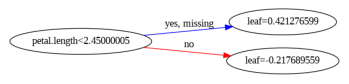

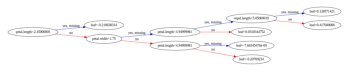

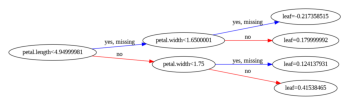

In [19]:
plot_trees(model_path, n_estimator, n_class)

## 4.0 Deploy the Model

We will show how to deploy the model as a micro-service. To do that, we will convert step as a component and add a deploy step. This part is not shown in this notebook.

In [20]:
MODEL = pickle.load(open(model_path, 'rb'))

In [21]:
input_datapoint = np.array([5.5,2.4,3.8,1.1])

In [22]:
input_datapoint.reshape(-1, 4)

array([[5.5, 2.4, 3.8, 1.1]])

In [23]:
result = MODEL.predict(input_datapoint.reshape(1, 4))

In [24]:
result

array([1])

In [25]:
label_encoder = pickle.load(open('./processed_data/labelEncoder.pkl', 'rb'))

In [26]:
label = label_encoder.inverse_transform(result)

In [27]:
label

array(['Versicolor'], dtype=object)

In [28]:
label.tolist()

['Versicolor']